# Discriminant Analysis - Assignment #3
In this jupyter notebook, we will create a **Latent Dirichlet Allocation (LDA) model** for the `heartfailure.csv` dataset. The dataset is available on the [UCI Machine Learning Repository website](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records).
![UCI-screenshot](../images/heart-failure-uci-screenshot.png)

---

**Lecturer: Sam Plati**<br></br>
**Module: DATA 2204 - Statistical Pred Modelling**

---

# Table of Contents:
* [1. Dataset Information](#dataset-information)
* [2. Loading Data](#loading-data)
* [3. Pre-Processing Data](#preprocessing-data)
* [4. Modelling and Evaluation](#modelling)
    * [4.1 Standard Model](#standard-model)
    * [4.2 Create Pipeline](#create-pipeline)
    * [4.3 Model Analysis - Learning Curve and Recall](#model-analysis)
    * [4.2 Optimized Model](#optimized-model)

---

Background for the dataset (source: [BMC - Part of Springer Nature](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5)):

> "Cardiovascular diseases kill approximately 17 million people globally every year, and they mainly exhibit as myocardial infarctions and heart failures. Heart failure (HF) occurs when the heart cannot pump enough blood to meet the needs of the body. Available electronic medical records of patients quantify symptoms, body features, and clinical laboratory test values, which can be used to perform biostatistics analysis aimed at highlighting patterns and correlations otherwise undetectable by medical doctors. Machine learning, in particular, can predict patients’ survival from their data and can individuate the most important features among those included in their medical records."

---

<a id="dataset-information"></a>
# 1. Dataset Information

## Independent Variables

- `age`: age of the patient (years)
- `anaemia`: decrease of red blood cells or hemoglobin (boolean)
- `high blood pressure`: if the patient has hypertension (boolean)
- `creatinine phosphokinase (CPK)`: level of the CPK enzyme in the blood (mcg/L)
- `diabetes`: if the patient has diabetes (boolean)
- `ejection fraction`: percentage of blood leaving the heart at each contraction (percentage)
- `platelets`: platelets in the blood (kiloplatelets/mL)
- `sex`: woman or man (binary)
- `serum creatinine`: level of serum creatinine in the blood (mg/dL)
- `serum sodium`: level of serum sodium in the blood (mEq/L)
- `smoking`: if the patient smokes or not (boolean)
- `time`: follow-up period (days)

## Dependent Variable
- `death event`: if the patient deceased during the follow-up period (0-Alive, 1-Deceased)

<a id="loading-data"></a>
# 2. Loading Data

In [22]:
#Load Libraries
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display, IFrame

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

try:
    import eli5
    from eli5.sklearn import PermutationImportance
except ModuleNotFoundError:
    print('pip installing eli5 package')
    !pip install eli5 --quiet
    import eli5
    from eli5.sklearn import PermutationImportance

from mlxtend.evaluate import bias_variance_decomp

import os
import pathlib
import json
from pprint import pprint

In [2]:
# Define location of the data
data_dir = '../data'
filename = 'heartfailure.csv'
data_path = os.path.join(data_dir, filename)

if not pathlib.Path(data_path).exists():
    raise FileNotFoundError('No file found at defined location.')

In [3]:
# Load data into a pandas DataFrame
data = pd.read_csv(data_path)
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# Overview of Dataset Characteristics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
# Check for any missing values
data.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [6]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [7]:
# Profile Report
data2 = pp.ProfileReport(data)
data2.to_file('heartfailureLogR.html')
display(IFrame('heartfailureLogR.html', width=900, height=350))

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

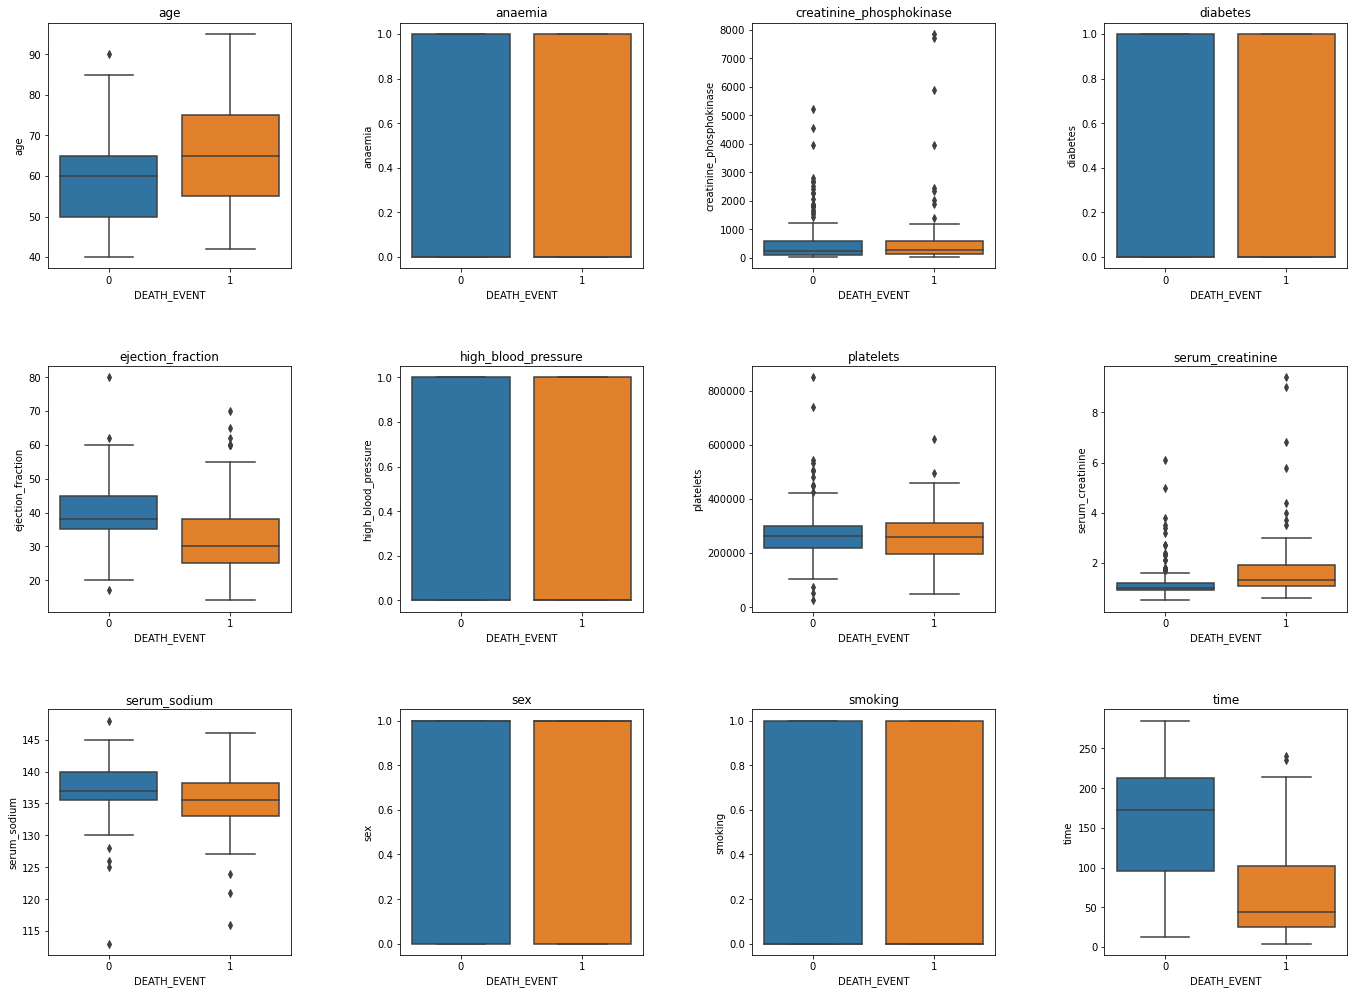

In [8]:
def boxplot(data_df: pd.DataFrame, dep_variable: str = None, ind_variables: list = None):
    """
    The function takes the dataframe and creates a boxplot for all the variables in the
    DataFrame if ind_variables is `None`.
    
    data_df (pd.DataFrame): a pandas dataframe with all the data to be plotted.
    dep_variable (str): name of the column in data_df that contains the dependent variable. If `None`
                        it will be ignored.
    ind_variables (list of str): contains the column names from data_df that should be plotted. If
                                 `None`, all the variables will be plotted.
    """


    if ind_variables is None:
        if dep_variable is None: 
            ind_variables = data_df.columns
        else:
            ind_variables = data_df.drop(dep_variable, axis=1).columns
        
    n_cols = 4
    n_rows = round(len(ind_variables) / n_cols) + (len(ind_variables) % n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                             figsize=(n_cols*5,n_rows*5))
    idx = 0
    
    for row_num in range(n_rows):
        for col_num in range(n_cols):
            sns.boxplot(data=data_df,y=ind_variables[idx],x=dep_variable,ax=axes[row_num,col_num])
            axes[row_num,col_num].set_title(ind_variables[idx])
            idx += 1
    
    fig.tight_layout(pad=5)
    
boxplot(data, "DEATH_EVENT")

Class Split
0    203
1     96
Name: DEATH_EVENT, dtype: int64


Text(0, 0.5, 'Count')

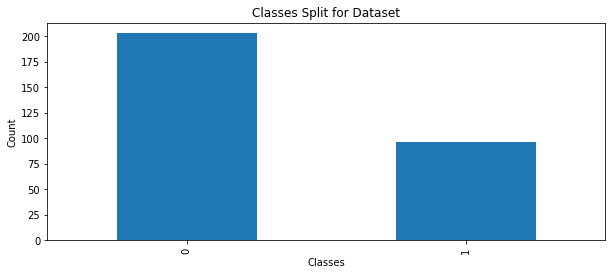

In [9]:
#Class Balance
print('Class Split')
print(data['DEATH_EVENT'].value_counts())
data['DEATH_EVENT'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

In [10]:
#Find Independent Column Correlations
def correlation(dataset,threshold):
    col_corr= [] # List of correlated columns
    corr_matrix=dataset.corr() #finding correlation between columns
    for i in range (len(corr_matrix.columns)): #Number of columns
        for j in range (i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking correlation between columns
                colName=(corr_matrix.columns[i], corr_matrix.columns[j]) #getting correlated columns
                col_corr.append(colName) #adding correlated column name
    return col_corr #returning set of column names

col=correlation(data,0.8)
print('Correlated columns @ 0.8:')
pprint(col, indent=3)

Correlated columns @ 0.8:
[]


In [19]:
#Covariance test - Levene Test

#   p <= alpha(0.05): reject H0, not the same covariance.
#   p > alpha(0.05): fail to reject H0, same covariance.

import scipy.stats as stats
names=data.get('DEATH_EVENT')

cnt=1
for col in data.columns:
    if (col=='DEATH_EVENT'):
        continue
        
    stat, p = stats.levene(data[col][data['DEATH_EVENT'] == names[0]], 
               data[col][data['DEATH_EVENT'] == names[1]])

    print(col)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Covariance the Same (fail to reject H0)')
        print('\n')
    else:
        print('Covariance different(reject H0)')
        print('\n')
    cnt +=1    

age
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


anaemia
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


creatinine_phosphokinase
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


diabetes
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


ejection_fraction
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


high_blood_pressure
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


platelets
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


serum_creatinine
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


serum_sodium
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


sex
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


smoking
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)


time
Statistics=0.000, p=1.000
Covariance the Same (fail to reject H0)




<a id="preprocessing-data"></a>
# 3. Pre-Processing

In [11]:
# Define x and y variables for CMS prediction
x = data.drop('DEATH_EVENT', axis=1).to_numpy()
y = data["DEATH_EVENT"].to_numpy()

# Splitting data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=100, stratify=y)

In [12]:
#Current Class Balance - Test Data
print('Current - Class Split')
num_zeros = (y_train == 0).sum()
num_ones = (y_train == 1).sum()
print('Class 0 -',  num_zeros)
print('Class 1 -',  num_ones)

Current - Class Split
Class 0 - 162
Class 1 - 77


In [28]:
#SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Class Balance - Test Data
print('Train Data - Class Split')
num_zeros = (y_train_smt == 0).sum()
num_ones = (y_train_smt == 1).sum()
print('Class 0 -',  num_zeros)
print('Class 1 -',  num_ones)

# Scaling the data
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.transform(x_test)

Train Data - Class Split
Class 0 - 162
Class 1 - 162


<a id="modelling"></a>
# 4. Modelling


<a id="standard-model"></a>
## 4.1 Standard Model

In [29]:
#Base LDA, QDA and Logistical Regression Model
from sklearn.metrics import classification_report, confusion_matrix  

for name,method in [('LDA', LinearDiscriminantAnalysis())]: 
    method.fit(x_train2,y_train_smt)
    predict = method.predict(x_test2)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))      


Estimator: LDA
[[34  7]
 [ 5 14]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        41
           1       0.67      0.74      0.70        19

    accuracy                           0.80        60
   macro avg       0.77      0.78      0.78        60
weighted avg       0.81      0.80      0.80        60



<a id="create-pipeline"></a>
## 4.2 Create Pipeline

In [30]:
# Construct some pipelines 

#Create Pipeline

pipeline =[]

pipe_lda = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearDiscriminantAnalysis())])

pipeline.insert(0,pipe_lda)

# Set grid search params 

modelpara =[]

param_gridlda = {'clf__solver':['svd','lsqr','eigen']}
modelpara.insert(0,param_gridlda)

<a id="model-analysis"></a>
## 4.3 Model Analysis - Learning Curve and Recall

In [32]:
#Define Plot for learning curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train_smt, 
                                                            y=y_train_smt,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.6, 1.0])
    plt.show()

LDA Learning Curve


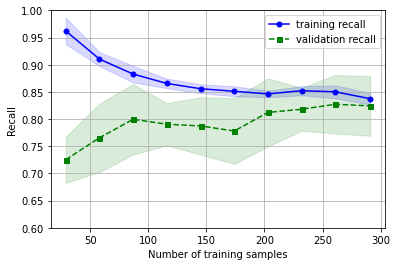

In [34]:
# Plot Learning Curve
print('LDA Learning Curve')
plot_learning_curves(pipe_lda)

Model Evaluation - Recall Weighted
LDA 0.83 +/- 0.08




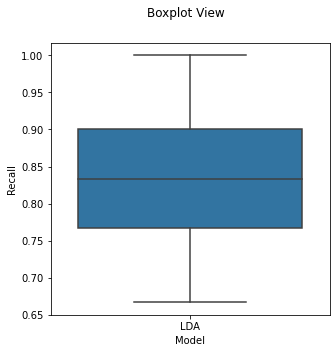

In [35]:
#Model Analysis

models=[]
models.append(('LDA',pipe_lda))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Weighted')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

<a id="optimized-model"></a>
## 4.4 Optimized Model

In [36]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train_smt, y_train_smt)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
        
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   


Optimized Model

Model Name: LinearDiscriminantAnalysis()

Best Parameters: {'clf__solver': 'svd'}

 [[34  7]
 [ 5 14]]

               precision    recall  f1-score   support

   Outcome 0       0.87      0.83      0.85        41
   Outcome 1       0.67      0.74      0.70        19

    accuracy                           0.80        60
   macro avg       0.77      0.78      0.78        60
weighted avg       0.81      0.80      0.80        60

ROC Curve


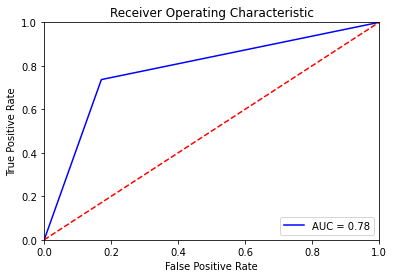

In [37]:
# Run Models
for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)